# Answerability Classification

IMPORTANT NOTE: this notebook has the purpose to show that the training of `roberta-base` on answerability classification took place. To all the explaination on how the dataset is prepared, preprocessed and how the model is trained please refer to the `Anserability Classification` notebook where everything is explained in detail and a comparison between all different trained models is shown.

In [1]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 5.4 MB/s eta 0:00:00


In [2]:
import random
import json
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DefaultDataCollator
from transformers import TrainingArguments
from transformers import Trainer
from torch.utils.data import DataLoader
from transformers import default_data_collator
from accelerate import Accelerator
from transformers import BertForQuestionAnswering
from tqdm.auto import tqdm
from torch.optim import AdamW
from transformers import get_scheduler

In [3]:
import os
from google.colab import drive

# Mount the Google drive storage
drive.mount('/content/drive')

# Move to the directory with the notebooks and the data set
# (note, you may need to change this path according to your directory structure)
os.chdir('/content/drive/MyDrive/NLP_project/dataset/')

# Check the currect working directory
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/NLP_project/dataset'

## Loading of the dataset SQuAD 2.0

In [ ]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['data']

train_json = load_data('train-v2.0.json')
validation_json = load_data('dev-v2.0.json')

In [ ]:
def extract_data_from_json(data):
    dataset = []

    for article in data:
        for paragraph in article['paragraphs']:
            for qas in paragraph['qas']:
                if qas['is_impossible'] == False: 
                    dataset.append({'id': qas['id'],
                                    'context': paragraph['context'],
                                   'question': qas['question'],
                                   'answers': {'text' : [qas['answers'][0]['text']], 'answer_start': [int(qas['answers'][0]['answer_start'])]},
                                    'is_possible': True
                    })
                else:
                    dataset.append({'id': qas['id'],
                                    'context': paragraph['context'],
                                   'question': qas['question'],
                                   'answers': {'text' : [''], 'answer_start': [0]},
                                    'is_possible': False
                    })

    return dataset

train_data = extract_data_from_json(train_json)
dev_data = extract_data_from_json(validation_json)

#train_data = random.sample(train_data, int(len(train_data) * 0.2))

In [ ]:
raw_datasets = DatasetDict()
raw_datasets['train'] = Dataset.from_list(train_data)
raw_datasets['validation'] = Dataset.from_list(dev_data)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answers', 'is_possible'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'answers', 'is_possible'],
        num_rows: 11873
    })
})

In [ ]:
print("Training Set")
print("Total question: ", len(raw_datasets['train']["is_possible"]))
print("Total answerable: ", sum(raw_datasets['train']["is_possible"]))
print("Total unanswerable: ", len(raw_datasets['train']["is_possible"])-sum(raw_datasets['train']["is_possible"]))

Training Set
Total question:  130319
Total answerable:  86821
Total unanswerable:  43498


In [ ]:
print("Validation Set")
print("Total question: ", len(raw_datasets['validation']["is_possible"]))
print("Total answerable: ", sum(raw_datasets['validation']["is_possible"]))
print("Total unanswerable: ", len(raw_datasets['validation']["is_possible"])-sum(raw_datasets['validation']["is_possible"]))

Validation Set
Total question:  11873
Total answerable:  5928
Total unanswerable:  5945


## Hyper-parameters

In [ ]:
max_length = 384
stride = 128
num_train_epochs = 3
learning_rate = 2e-5
n_best = 20
max_answer_length = 50

## Preprocessing

In [4]:
model_name = "roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def preprocess(data):
    questions = [q.strip() for q in data["question"]]
    inputs = tokenizer(
        questions,
        data["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = data["answers"]
    is_possible = data["is_possible"]
    labels = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if is_possible[sample_idx] == False:
          labels.append(0)
        else:
          # If the answer is not fully inside the context, label is (0, 0)
          if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            labels.append(0)
          else:
            labels.append(1)

    inputs["labels"] = labels
    return inputs

In [ ]:
train_dataset = raw_datasets["train"].map(
    preprocess,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
len(raw_datasets["train"]), len(train_dataset)

Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

(130319, 131821)

In [ ]:
validation_dataset = raw_datasets["validation"].map(
    preprocess,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
len(raw_datasets["validation"]), len(validation_dataset)

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

(11873, 12165)

## Class Balancing (upsampling)

In [ ]:
print("Training Set")
print("Total question: ", len(train_dataset["labels"]))
print("Total answerable: ", sum(train_dataset["labels"]))
print("Total unanswerable: ", len(train_dataset["labels"])-sum(train_dataset["labels"]))

Training Set
Total question:  131821
Total answerable:  87002
Total unanswerable:  44819


In [ ]:
print("Validation Set")
print("Total question: ", len(validation_dataset["labels"]))
print("Total answerable: ", sum(validation_dataset["labels"]))
print("Total unanswerable: ", len(validation_dataset["labels"])-sum(validation_dataset["labels"]))

Validation Set
Total question:  12165
Total answerable:  5952
Total unanswerable:  6213


In [ ]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 131821
})

In [ ]:
answerable_training = pd.DataFrame(train_dataset.filter(lambda example: example['labels'] == 1))
unanswerable_training = pd.DataFrame(train_dataset.filter(lambda example: example['labels'] == 0))

Filter:   0%|          | 0/131821 [00:00<?, ? examples/s]

Filter:   0%|          | 0/131821 [00:00<?, ? examples/s]

In [ ]:
unanswerable_training = unanswerable_training.sample(n=len(answerable_training), random_state=42, replace=True)

In [ ]:
balanced_training = pd.concat([answerable_training, unanswerable_training])

balanced_training = balanced_training.sample(frac=1, random_state=42)

In [ ]:
upsampled_training = Dataset.from_pandas(balanced_training)

In [ ]:
print("Balanced Training Set")
print("Total question: ", len(upsampled_training["labels"]))
print("Total answerable: ", sum(upsampled_training["labels"]))
print("Total unanswerable: ", len(upsampled_training["labels"])-sum(upsampled_training["labels"]))

Balanced Training Set
Total question:  174004
Total answerable:  87002
Total unanswerable:  87002


In [ ]:
answerable_validation = pd.DataFrame(validation_dataset.filter(lambda example: example['labels'] == 1))
unanswerable_validation = pd.DataFrame(validation_dataset.filter(lambda example: example['labels'] == 0))

Filter:   0%|          | 0/12165 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12165 [00:00<?, ? examples/s]

In [ ]:
answerable_validation = answerable_validation.sample(n=len(unanswerable_validation), random_state=42, replace=True)

In [ ]:
balanced_validation = pd.concat([answerable_validation, unanswerable_validation])

balanced_validation = balanced_validation.sample(frac=1, random_state=42)

In [ ]:
upsampled_validation = Dataset.from_pandas(balanced_validation)

In [ ]:
print("Balanced Validation Set")
print("Total question: ", len(upsampled_validation["labels"]))
print("Total answerable: ", sum(upsampled_validation["labels"]))
print("Total unanswerable: ", len(upsampled_validation["labels"])-sum(upsampled_validation["labels"]))

Balanced Validation Set
Total question:  12426
Total answerable:  6213
Total unanswerable:  6213


## Roberta Base Training

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [ ]:
args = TrainingArguments(
    model_name,
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=learning_rate,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    fp16=True,
    metric_for_best_model="f1"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=upsampled_training,
    eval_dataset=upsampled_validation,
    tokenizer=tokenizer,
)
trainer.train(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
22000,0.253500
22500,0.279900
23000,0.264000
23500,0.273700
24000,0.276600
24500,0.289600
25000,0.275800
25500,0.291000
26000,0.267300
26500,0.284800


TrainOutput(global_step=65253, training_loss=0.13114306756937225, metrics={'train_runtime': 10450.954, 'train_samples_per_second': 49.949, 'train_steps_per_second': 6.244, 'total_flos': 1.0301034617293824e+17, 'train_loss': 0.13114306756937225, 'epoch': 3.0})

## Evaluation

In [11]:
print("Architure: ")
print(model)

Architure: 
RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
 

In [12]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters:", total_params)

Total number of parameters: 124647170


In [ ]:
predictions, labels, _ = trainer.predict(upsampled_validation)

In [ ]:
print("Total question: ", len(labels))
print("Total answerable: ", sum(labels))
print("Total unanswerable: ", len(labels)-sum(labels))

Total question:  12426
Total answerable:  6213
Total unanswerable:  6213


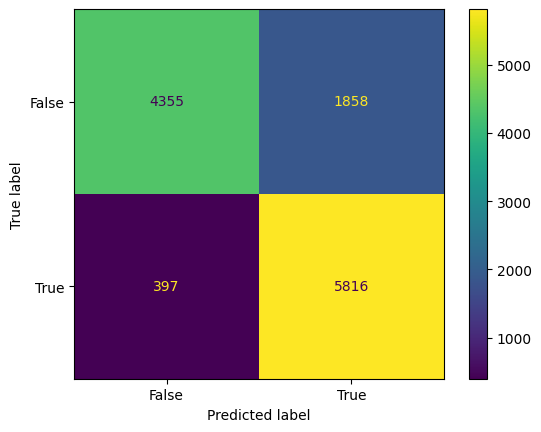

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

actual = np.random.binomial(1,.9,size = 1000)
predicted = np.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(labels, np.argmax(predictions, axis=1))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(labels, np.argmax(predictions, axis=1))
recall = recall_score(labels, np.argmax(predictions, axis=1))
accuracy = accuracy_score(labels, np.argmax(predictions, axis=1))
f1 = f1_score(labels, np.argmax(predictions, axis=1))

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1-score:", f1)

Precision: 0.7578837633567892
Recall: 0.9361017221953968
Accuracy: 0.8185256719781104
F1-score: 0.837617916036581
